In [2]:
from models import TransformerModel
import torch
import lightning
import utils
import numpy as np


In [3]:
path = "reports/transformer-logs/TNN_ne1_nd1_sl12_tl12_nh2_df64/checkpoints/epoch=34-step=1260.ckpt"
model = TransformerModel.load_from_checkpoint(path, map_location={"cuda:0": "cpu"})
model : TransformerModel
SEQ_LENGTH = 12
model


TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=4, out_features=4, bias=True)
          )
          (linear1): Linear(in_features=4, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=64, out_features=4, bias=True)
          (norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0): Transfo

In [4]:
import pandas as pd

df_train, df_test, df_valid, mu, std = utils.load_cleaned_data()

df_concatenated = pd.concat([df_valid, df_train])
df_test_extended = pd.concat([df_concatenated.iloc[-SEQ_LENGTH:], df_test])


Mean Squared Error: 16.856460883711968
Root Mean Squared Error: 4.105662051814782


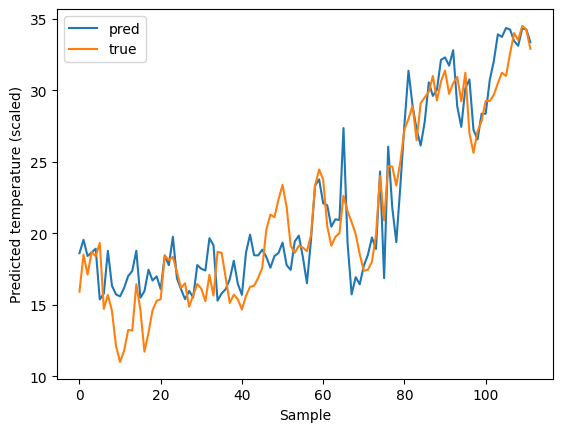

In [5]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test_extended, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)

preds, true = model.predict(dataloader_test)

preds = preds * std.to_numpy() + mu.to_numpy()
true = true * std.to_numpy() + mu.to_numpy()


true = true.reshape(true.shape[0], true.shape[-1])
preds = preds.reshape(preds.shape[0], preds.shape[-1])

mse = mean_squared_error(true, preds)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))
plt.plot(preds[:,0], label="pred")
plt.plot(true[:,0], label="true")
plt.xlabel('Sample')
plt.ylabel('Predicted temperature (scaled)')
plt.legend()
plt.show()


In [6]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error


dataloader_test = torch.utils.data.DataLoader(utils.ClimateDataset(df_test_extended, SEQ_LENGTH), batch_size=1, shuffle=False, num_workers=15)

x = torch.tensor(df_concatenated.iloc[-SEQ_LENGTH-1:-1].to_numpy().astype(np.float32)).unsqueeze(0)
tgt = torch.tensor(df_concatenated.iloc[-1].to_numpy().astype(np.float32)).unsqueeze(0).unsqueeze(0)
preds = model.autoregressive_predict(x, tgt, df_test.shape[0])
preds = np.array(preds)




Mean Squared Error: 23.922150912722884
Root Mean Squared Error: 4.891027592717392


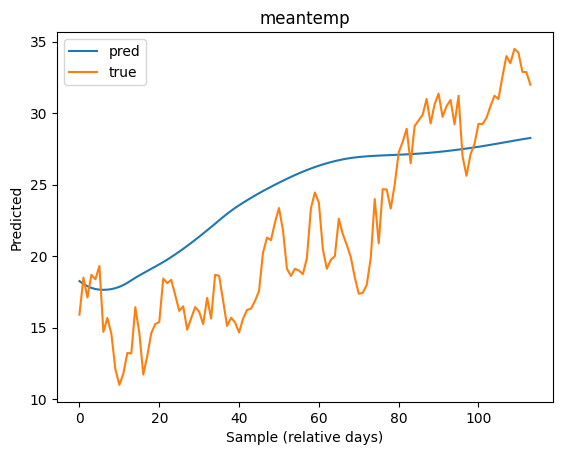

Mean Squared Error: 632.6636672666608
Root Mean Squared Error: 25.152806349722905


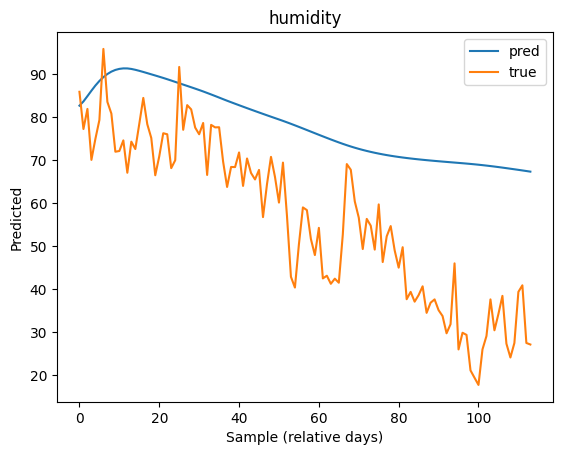

Mean Squared Error: 18.01175853089856
Root Mean Squared Error: 4.244026217037138


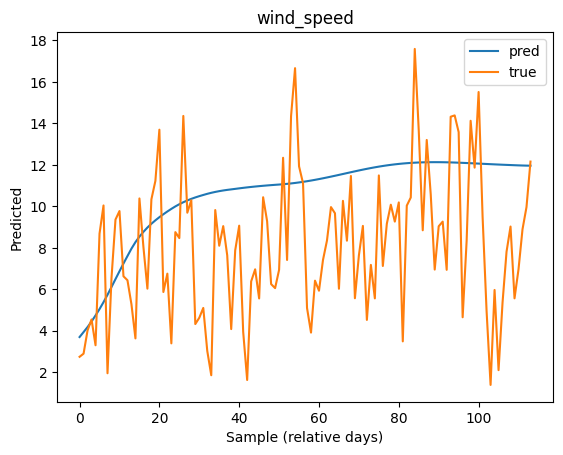

Mean Squared Error: 180.10751238092624
Root Mean Squared Error: 13.420414016748001


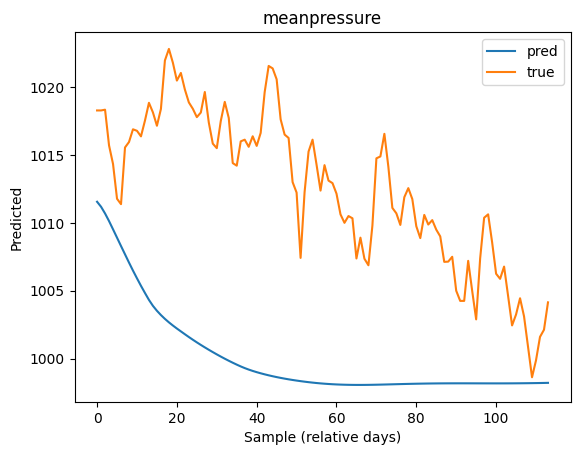

In [7]:

true = df_test.to_numpy()

preds = preds * std.to_numpy() + mu.to_numpy()
true = true * std.to_numpy() + mu.to_numpy()


for i, name in enumerate(df_test.columns):
    # p = preds[:,:,i].reshape(true[:,i].shape)
    p = preds[:,i].reshape(true[:,i].shape)
    mse = mean_squared_error(true[:,i], p)
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", np.sqrt(mse))
    plt.plot(p, label="pred")
    plt.plot(true[:,i], label="true")
    plt.xlabel('Sample (relative days)')
    plt.ylabel(f'Predicted')
    plt.title(name)
    plt.legend()
    plt.show()


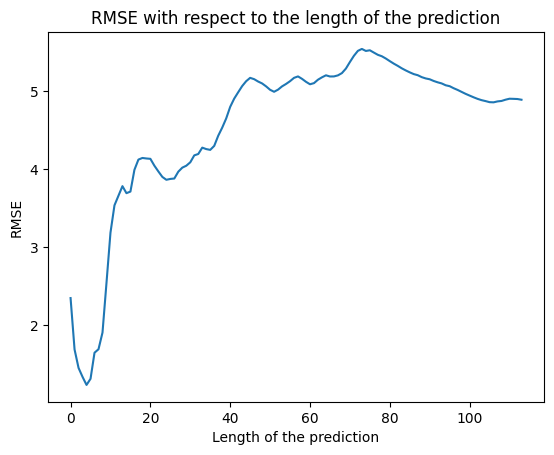

In [8]:
true_t = true[:,0]
preds_t = preds.reshape(preds.shape[0], preds.shape[-1])[:,0]

rmses = []
for i in range(1, true_t.shape[-1]+1):
    mse = mean_squared_error(true_t[:i], preds_t[:i])
    rmse = np.sqrt(mse)
    rmses.append(rmse)

plt.title("RMSE with respect to the length of the prediction")
plt.plot(rmses)
plt.xlabel("Length of the prediction")
plt.ylabel("RMSE")
plt.show()